In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
from copy import deepcopy

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
out = 'train_bench_gmsc.csv'

In [5]:
df = pd.read_csv(out)
target = 'SeriousDlqin2yrs'  # ' <=50K'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "test"], p =[.8, .2], size=(df.shape[0],))

train_indices = df[df.Set=="train"].index
test_indices = df[df.Set=="test"].index

In [6]:
df.drop('Unamed', axis=1, inplace=True)

In [7]:
train = df.loc[df.Set=="train"].reset_index(drop=True)
test = df.loc[df.Set=="test"].reset_index(drop=True)

In [8]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Set
0,0,0.550178,58,1,0.383287,10829.0,12,0,2,0,2.0,train
1,0,0.097876,82,0,0.006454,77000.0,7,0,1,0,0.0,train
2,0,0.028904,62,0,0.004142,7000.0,7,0,0,0,0.0,train
3,1,0.012218,53,1,0.134993,6666.0,6,0,0,0,1.0,train
4,0,0.191007,48,3,0.619689,5200.0,8,0,1,0,1.0,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [9]:
class Encoder():
    def __init__(self, nan_value='VV_likely', other_values='VV_UOthER'):
        super().__init__()
        self.nan_value = nan_value
        self.other_values = other_values
        self.l_enc = LabelEncoder()
        
    def fit(self, X):
        self.l_enc.fit(pd.concat([X.astype(str), pd.Series([self.nan_value, self.other_values])]))
        self.classes_ = self.l_enc.classes_
    
    def transform(self, X):
        X = X.astype(str).apply(lambda x: self.other_values if (x not in self.l_enc.classes_ and not pd.isnull(x)) else x)
        X = X.fillna(self.nan_value)
        return self.l_enc.transform(X)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [10]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object':
        print(col, train[col].nunique())
        l_enc = Encoder()
        train[col] = l_enc.fit_transform(train[col])
        test[col] = l_enc.transform(test[col])
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        qt = QuantileTransformer()
        train[col].fillna(train[col].min() - 1, inplace=True)
        test[col].fillna(train[col].min() - 1, inplace=True)
        
        train[col] = qt.fit_transform(train[col].values.reshape(-1, 1))
        test[col] = qt.transform(test[col].values.reshape(-1, 1))

Set 1


# Define categorical features for categorical embeddings

In [11]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Training

In [12]:
X_train = train[features].values
y_train = train[target].values

X_test = test[features].values
y_test = test[target].values

In [13]:
def split_and_preprocess(X_train, y_train, n_splits=8, random_state=0):
   
    
    # CVSplit = KFold if self.learning_task == 'regression' else StratifiedKFold
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in cv.split(X_train, y_train):
        train, test = X_train[train_index], X_train[test_index]
        train, ytr = train.astype(float), y_train[train_index]
        test, yte = test.astype(float), y_train[test_index]
        yield train.astype(float), ytr, test.astype(float), yte

In [14]:
evals_results = []
clfs = []
for _train, _ytr, _test, _yte in split_and_preprocess(X_train, y_train):
    clf = TabNetClassifier(n_d=8, n_a=8, cat_idxs=cat_idxs, cat_dims=cat_dims,cat_emb_dim=1)
    evals_result = clf.fit(
        X_train=_train, y_train=_ytr,
        X_valid=_test, y_valid=_yte,
        max_epochs=1000, patience=20,
        batch_size=2048, virtual_batch_size=512,
        num_workers=4,
        drop_last=False
    )
    print(evals_result)
    evals_results.append(evals_result)
    clfs.append(deepcopy(clf))

Device used : cuda
Will train until validation stopping metric hasn't improved in 20 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.23144 |  0.21069 |   1.9       
| 2     | 0.19231 |  0.19909 |   3.8       
| 3     | 0.18825 |  0.18774 |   5.9       
| 4     | 0.18571 |  0.18601 |   7.8       
| 5     | 0.18505 |  0.18426 |   9.7       
| 6     | 0.18445 |  0.18184 |   11.5      
| 7     | 0.18306 |  0.17974 |   13.2      
| 8     | 0.18262 |  0.18086 |   15.0      
| 9     | 0.18248 |  0.18026 |   16.7      
| 10    | 0.18250 |  0.17969 |   18.5      
| 11    | 0.18212 |  0.18118 |   20.2      
| 12    | 0.18285 |  0.18147 |   21.9      
| 13    | 0.18289 |  0.18152 |   23.7      
| 14    | 0.18265 |  0.18119 |   25.5      
| 15    | 0.18258 |  0.18024 |   27.3      
| 16    | 0.18132 |  0.17993 |   29.0      
| 17    | 0.18072 |  0.17944 |   30.8      
| 18    | 0.18109 |  0.18021 |   32.6      
| 19    | 0.18078 |  0.18027 

| 1     | 0.22957 |  0.21300 |   1.7       
| 2     | 0.19124 |  0.20799 |   3.3       
| 3     | 0.18657 |  0.20421 |   5.0       
| 4     | 0.18554 |  0.19641 |   6.6       
| 5     | 0.18427 |  0.18722 |   8.4       
| 6     | 0.18365 |  0.18826 |   10.0      
| 7     | 0.18318 |  0.18188 |   11.7      
| 8     | 0.18275 |  0.18171 |   13.4      
| 9     | 0.18185 |  0.18109 |   15.1      
| 10    | 0.18177 |  0.18178 |   16.8      
| 11    | 0.18149 |  0.18142 |   18.5      
| 12    | 0.18109 |  0.18104 |   20.3      
| 13    | 0.18105 |  0.18035 |   22.0      
| 14    | 0.18063 |  0.18208 |   23.8      
| 15    | 0.18107 |  0.18031 |   25.6      
| 16    | 0.18102 |  0.18156 |   27.5      
| 17    | 0.18076 |  0.18014 |   29.4      
| 18    | 0.18072 |  0.18140 |   31.2      
| 19    | 0.18081 |  0.18008 |   33.0      
| 20    | 0.18044 |  0.17965 |   34.7      
| 21    | 0.18062 |  0.18015 |   36.5      
| 22    | 0.18066 |  0.18245 |   38.4      
| 23    | 0.18056 |  0.18037 |  

| 45    | 0.17981 |  0.17624 |   75.4      
| 46    | 0.17968 |  0.17491 |   77.1      
| 47    | 0.17896 |  0.17561 |   78.8      
| 48    | 0.17978 |  0.17571 |   80.6      
| 49    | 0.18031 |  0.17612 |   82.2      
| 50    | 0.18079 |  0.17666 |   83.9      
| 51    | 0.17995 |  0.17594 |   85.7      
| 52    | 0.17971 |  0.17666 |   87.3      
| 53    | 0.17999 |  0.17848 |   89.0      
| 54    | 0.18118 |  0.17916 |   90.7      
| 55    | 0.18056 |  0.17732 |   92.4      
| 56    | 0.18014 |  0.17614 |   94.1      
| 57    | 0.18010 |  0.17484 |   95.9      
| 58    | 0.18010 |  0.17520 |   97.6      
| 59    | 0.17989 |  0.17788 |   99.3      
| 60    | 0.18014 |  0.17678 |   100.9     
| 61    | 0.18008 |  0.17615 |   102.7     
| 62    | 0.18004 |  0.17897 |   104.3     
Early stopping occured at epoch 62
Training done in 104.328 seconds.
---------------------------------------
0.17462749379683518
Device used : cuda
Will train until validation stopping metric hasn't improved 

### Predictions

In [15]:
for c in clfs:
    preds = c.predict_proba(X_test)
    print(roc_auc_score(y_score=preds[:,1], y_true=y_test))

0.8613843099276048
0.8613252408333787
0.8602035749092464
0.861547081881204
0.8618849162454717
0.8645837099626446
0.8557742439819829
0.8600269123559676


In [29]:
preds = 0
for c in clfs:
    preds += c.predict_proba(X_test) / len(clfs)
    
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL TEST SCORE FOR census-income : 0.8647627216614574


# Global explainability : feat importance summing to 1

In [17]:
clf.feature_importances_

array([3.67917179e-01, 5.32388244e-02, 1.09645185e-01, 8.12863796e-02,
       2.55622089e-02, 3.83718294e-06, 3.23123805e-01, 5.80269946e-03,
       7.44764352e-09, 3.34198748e-02])

# Local explainability and masks

In [18]:
explain_matrix, masks = clf.explain(X_test)

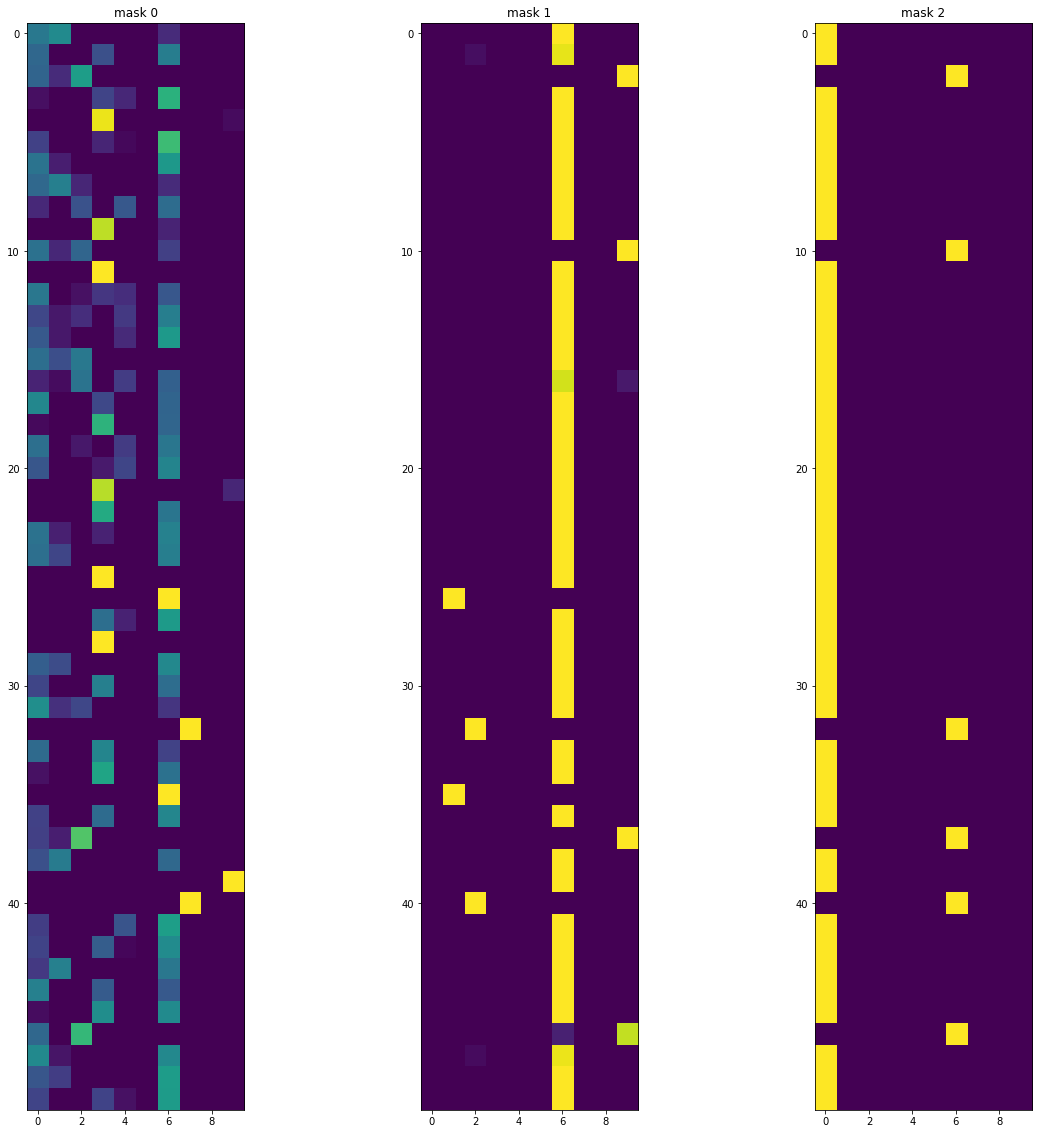

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
